In [1]:
#################################################################
#plotly libraries
import plotly.express as px
import plotly.colors as pc
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

#default renderer (svg means very small file size, visibility on github, high quality, but requires sometimes setting height and width)
pio.renderers.default = "svg"

colors = ["#363b3d", "#727b76", "#31a240", "#f93939", "#f79118", "#de7b06", "#9b308f", "#dc759b"]
#additional defaults
px.defaults.color_discrete_sequence = ["rgb(100,100,100)"] + pc.qualitative.D3
px.defaults.width=1000
px.defaults.height=800


#try setting this as default for histograms
#fig.update_traces(marker_line_width=0.2)

#pio.templates["simple_white"].layout.template.data.Histogram["marker_line_width"] = 0.2


#set default template as "simple_white" (no background, no grid lines)
pio.templates["simple_white"].layout["yaxis"]["showgrid"] = True
pio.templates.default = "simple_white"

import numpy as np

import sklearn.metrics as metrics
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

colorscale = pc.sequential.Plasma
colorscale = [colorscale[0]] + colorscale[3:8]


#fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))


In [9]:
illumina_samples = []
for replicate in ["Rep1", "Rep2"]:
    for DMS_conc in ["0mM", "8mM", "17mM", "34mM", "57mM", "85mM"]:
        for localization in ["cell", "virion"]:
            illumina_samples.append(f"{replicate}_RT1_{DMS_conc}_{localization}")
            


In [10]:
samples = illumina_samples

In [11]:
samples.remove("Rep1_RT1_34mM_virion")
samples.remove("Rep1_RT1_85mM_virion")
samples.remove("Rep2_RT1_34mM_virion")
samples.remove("Rep2_RT1_85mM_virion")

In [5]:
data_folder = "/vol/projects/pbohn/AnSo_DMS_MaP/_for_publication/1_US_default_and_optimization/data_illumina/"

In [12]:
samples

['Rep1_RT1_0mM_cell',
 'Rep1_RT1_0mM_virion',
 'Rep1_RT1_8mM_cell',
 'Rep1_RT1_8mM_virion',
 'Rep1_RT1_17mM_cell',
 'Rep1_RT1_17mM_virion',
 'Rep1_RT1_34mM_cell',
 'Rep1_RT1_57mM_cell',
 'Rep1_RT1_57mM_virion',
 'Rep1_RT1_85mM_cell',
 'Rep2_RT1_0mM_cell',
 'Rep2_RT1_0mM_virion',
 'Rep2_RT1_8mM_cell',
 'Rep2_RT1_8mM_virion',
 'Rep2_RT1_17mM_cell',
 'Rep2_RT1_17mM_virion',
 'Rep2_RT1_34mM_cell',
 'Rep2_RT1_57mM_cell',
 'Rep2_RT1_57mM_virion',
 'Rep2_RT1_85mM_cell']

In [13]:
combined_samples = [sample.replace("Rep1_", "") for sample in samples if "Rep1" in sample]
combined_samples

['RT1_0mM_cell',
 'RT1_0mM_virion',
 'RT1_8mM_cell',
 'RT1_8mM_virion',
 'RT1_17mM_cell',
 'RT1_17mM_virion',
 'RT1_34mM_cell',
 'RT1_57mM_cell',
 'RT1_57mM_virion',
 'RT1_85mM_cell']

In [7]:
import xml.etree.ElementTree as ET
import numpy as np

def read_in_xml(xml_file, sample):
    try:
        tree = ET.parse(xml_file)
    except:
        print("Could not read in xml file", xml_file, "from sample", sample)
        return {"sample" : sample, 
            "transcript_id" : "none",
            "length" : 0,
            "sequence" : "", 
            "reactivity" : np.nan
           }
    
    root = tree.getroot()
    
    transcript_id = root[0].attrib["id"]
    length = root[0].attrib["length"]
    sequence = root[0][0].text.replace("\t", "").replace("\n", "")
    reactivity = np.array(root[0][1].text.replace("\t", "").replace("\n", "").split(",")).astype(float)
    return {"sample" : sample, 
            "transcript_id" : transcript_id,
            "length" : length,
            "sequence" : sequence, 
            "reactivity" : reactivity
           }

In [19]:
combined_samples

['RT1_0mM_cell',
 'RT1_0mM_virion',
 'RT1_8mM_cell',
 'RT1_8mM_virion',
 'RT1_17mM_cell',
 'RT1_17mM_virion',
 'RT1_34mM_cell',
 'RT1_57mM_cell',
 'RT1_57mM_virion',
 'RT1_85mM_cell']

In [ ]:
data_folder = "/vol/projects/pbohn/AnSo_DMS_MaP/_for_publication/1_US_default_and_optimization/data_illumina"

In [50]:
tmp_data = []

isoform = "RT1_unspliced1"

for qscore in ["default", "minq20", "minq25", "minq33"]:

    rfcombine_dir = f"rfcombine_bowtie/{qscore}"
    for combined_sample in combined_samples:

        for option in ["q22_eq10_ndni", "q22_eq10", "default"]:
            for reactive_nt in ["ACGT", "AC", "ACT", "G"]:
                if "_0mM" in combined_sample:
                        norm_options = ["_raw"]
                else:
                    norm_options = ["", "_raw"]

                for norm_option in norm_options:

                    xml_file = f"{data_folder}/{rfcombine_dir}/{combined_sample}/{isoform}/{option}_{reactive_nt}{norm_option}/{isoform}.xml"

                    tmp_dict = read_in_xml(xml_file, combined_sample)
                    tmp_dict["setting"] = option
                    tmp_dict["reactive_nt"] = reactive_nt
                    tmp_dict["read_min_qscore"] = qscore
                    tmp_dict["norm_option"] = norm_option
                    
                    reactivity_file = xml_file.replace(f"{isoform}.xml", "correlation.csv")
                    try:
                        tmp_df = pd.read_csv(reactivity_file, sep=";", names=["isoform", "corr",  "p_value"])
                        corr = tmp_df["corr"].values[0]
                    except:
                        corr = np.nan
                    
                    tmp_dict["xml_corr"] = corr
                    
                    tmp_data.append(tmp_dict)

In [51]:
reactivity_df = pd.DataFrame(tmp_data)

In [52]:
from sklearn.metrics import roc_auc_score
def calc_AUC(reactivity, structure):
    if type(reactivity) != float:
        y_true = np.array(structure) == "."
        y_test = np.array(reactivity)
        #print(y_true)
        y_test = y_test[:len(y_true)]
        mask = ~np.isnan(y_test)
        return roc_auc_score(y_true[mask], y_test[mask])
    else:
        return np.nan
    

In [53]:
structure_file = f"{data_folder.replace('data_illumina', 'data')}/references/dimer_canonical_wo_sl_at_210.db"
with open(structure_file) as infile:
    name, sequence, structure = infile.readlines()
structure = list(structure.strip())
#structure

In [54]:
reactivity_df["rocauc"] = reactivity_df["reactivity"].apply(lambda x: calc_AUC(x, structure))

In [55]:
reactivity_df["DMS_conc"] = reactivity_df["sample"].apply(lambda x: x.split("_")[1])
reactivity_df["location"] = reactivity_df["sample"].apply(lambda x: x.split("_")[2])

In [56]:
cell_norm_df = reactivity_df[(reactivity_df["location"]=="cell") & (reactivity_df["norm_option"]=="")]

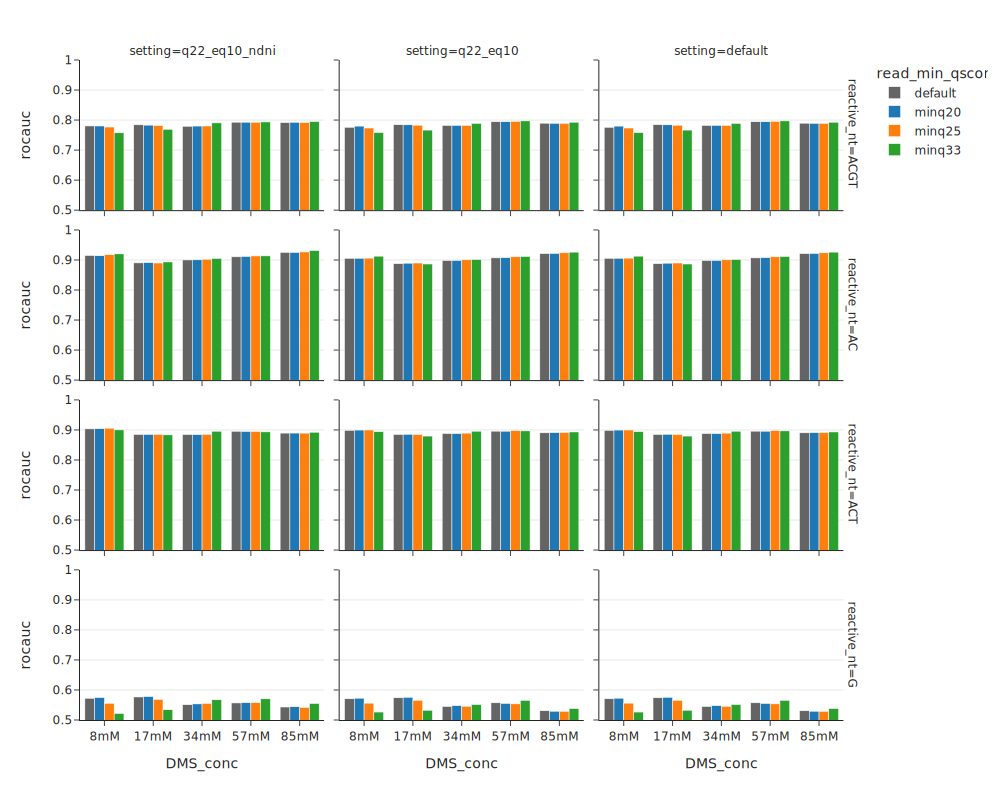

In [45]:
fig = px.bar(cell_norm_df, y="rocauc", x="DMS_conc", facet_col="setting", barmode="group", facet_row="reactive_nt", color="read_min_qscore")
fig.update_yaxes(range=[0.5,1],dtick=0.1)

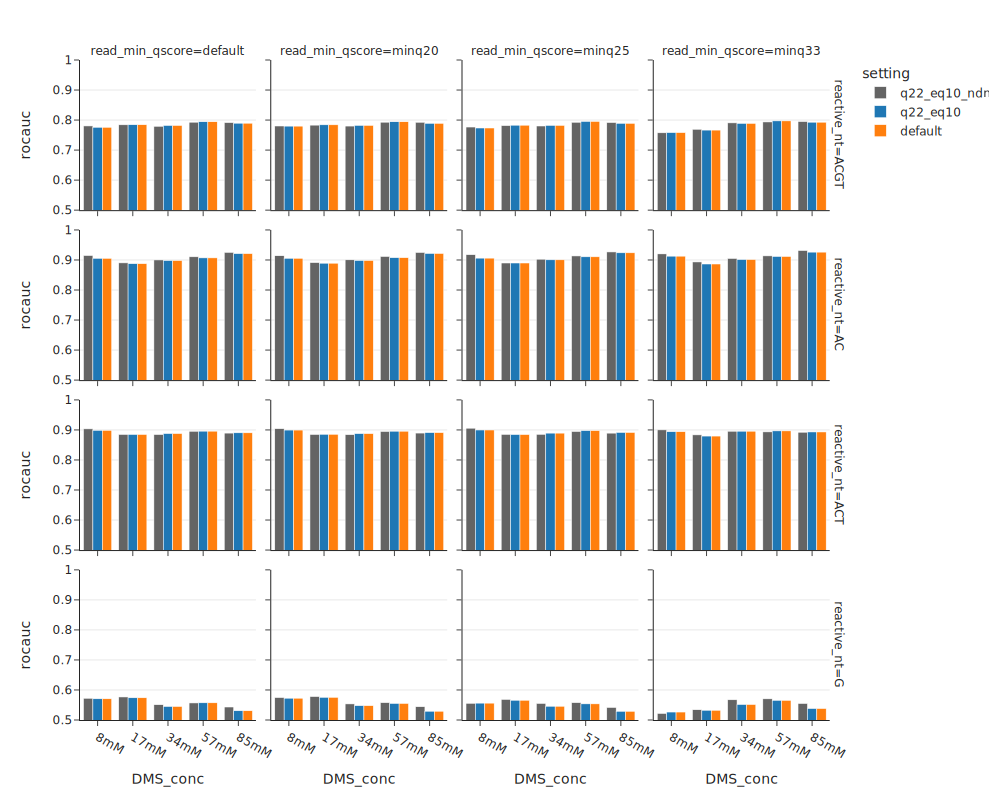

In [46]:
fig = px.bar(cell_norm_df, y="rocauc", x="DMS_conc", facet_col="read_min_qscore", barmode="group", facet_row="reactive_nt", color="setting")
fig.update_yaxes(range=[0.5,1],dtick=0.1)

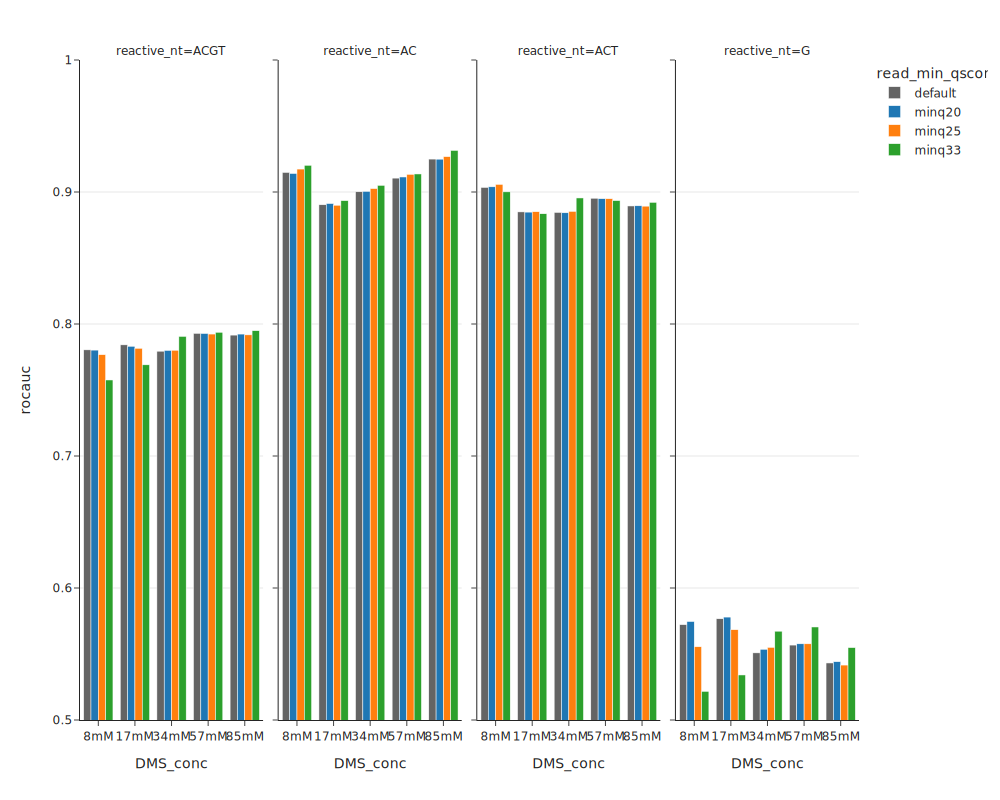

In [61]:
fig = px.bar(cell_norm_df[cell_norm_df["setting"] == "q22_eq10_ndni"], y="rocauc", x="DMS_conc", barmode="group", facet_col="reactive_nt", color="read_min_qscore")
fig.update_yaxes(range=[0.5,1],dtick=0.1)

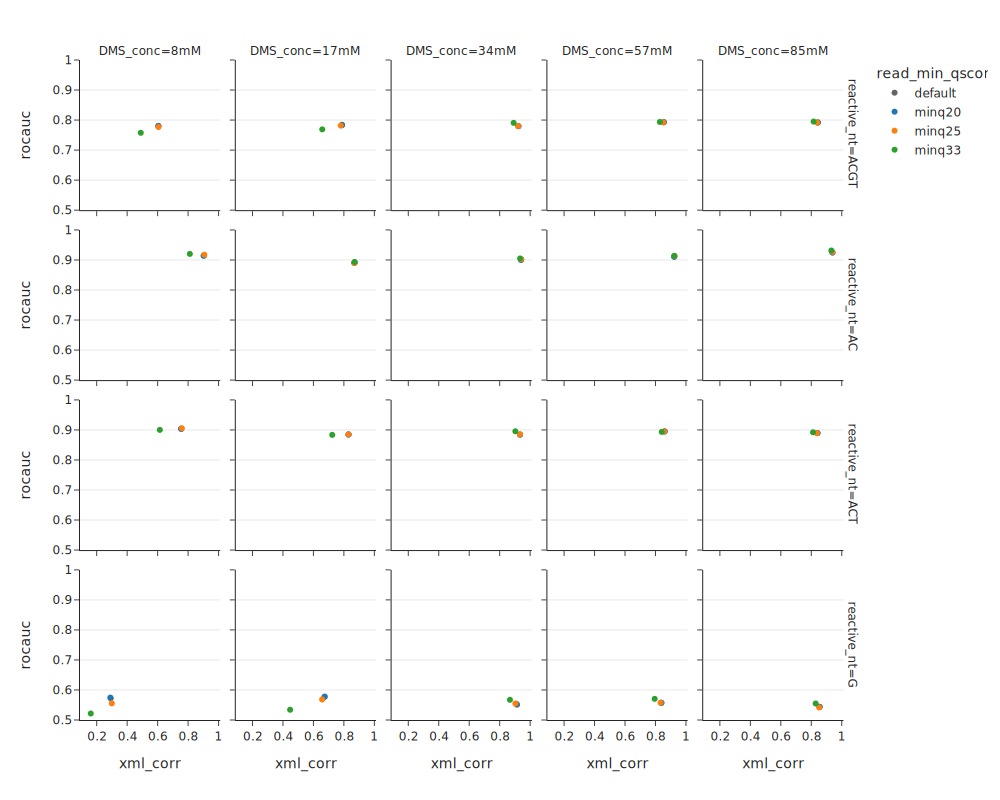

In [59]:
fig = px.scatter(cell_norm_df[cell_norm_df["setting"] == "q22_eq10_ndni"], x="xml_corr", y="rocauc", facet_col="DMS_conc",  facet_row="reactive_nt", color="read_min_qscore")
fig.update_yaxes(range=[0.5,1],dtick=0.1)

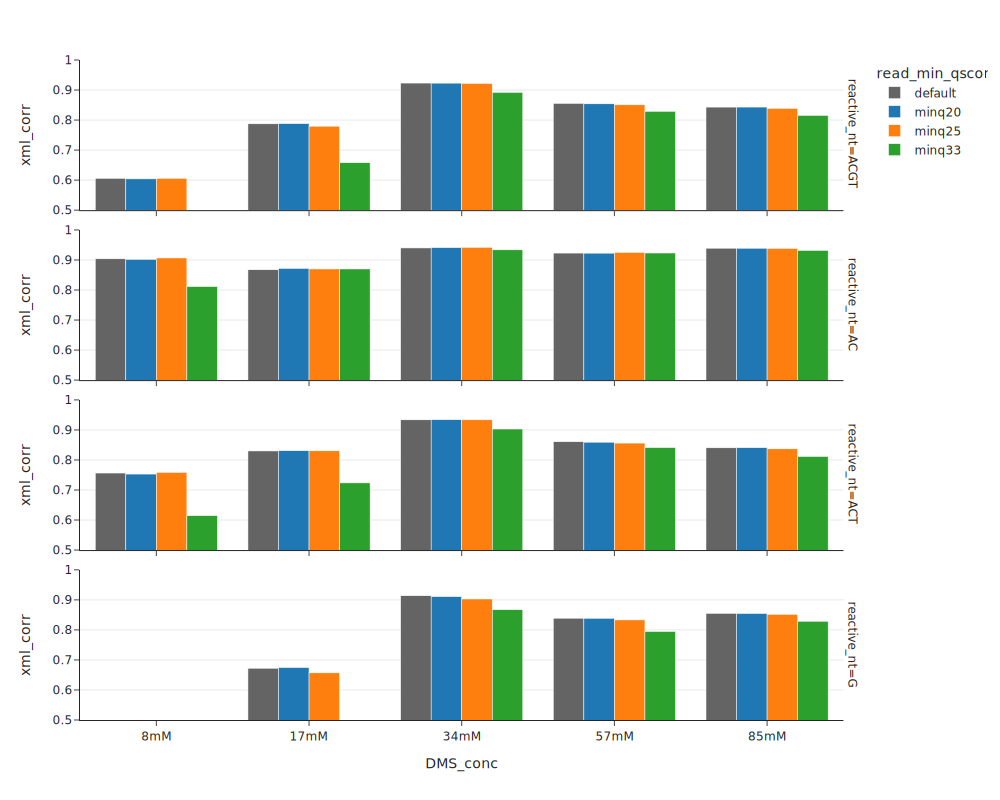

In [60]:
fig = px.bar(cell_norm_df[cell_norm_df["setting"] == "q22_eq10_ndni"], y="xml_corr", x="DMS_conc", barmode="group", facet_row="reactive_nt", color="read_min_qscore")
fig.update_yaxes(range=[0.5,1],dtick=0.1)